In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

In [2]:
agnetsCount = 500
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.005), np.arange(0.1, 0.31, 0.05)
])
distanceDs = np.concatenate([
    np.arange(0.1, 1.1, 0.05)
])
xIdxs = np.arange(len(distanceDs), step=6)
yIdxs = np.concatenate([np.arange(18, step=6), np.arange(18, 23, step=4)])

speedV = 3
dt = 0.01

targetPath = "lastStateRing_10.h5"  # lastStateRingForOP_5  # lastStateRing_5

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")

modelNums = totalPositionX.shape[0] // agnetsCount

totalPositionX = totalPositionX.values.reshape(modelNums, agnetsCount, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(modelNums, agnetsCount)
totalPointTheta = totalPointTheta.values.reshape(modelNums, agnetsCount)

idx = 0
positionX = dict()
phaseTheta = dict()
pointTheta = dict()

np.random.seed(10)
omegaTheta = np.random.uniform(1, 3, size=agnetsCount)

for l, d0 in product(rangeLambdas, distanceDs):
    
    positionX[f"{l:.3f}_{d0:.2f}"] = totalPositionX[idx]
    phaseTheta[f"{l:.3f}_{d0:.2f}"] = totalPhaseTheta[idx]
    pointTheta[f"{l:.3f}_{d0:.2f}"] = totalPointTheta[idx]

    idx += 1

In [54]:
maps1 = pd.read_csv("L10mono_mean_R_step10.csv", index_col=0)
maps1.index = np.round(maps1.index.astype(float), 4)
maps1.columns = np.round(maps1.columns.astype(float), 4)

maps2 = pd.read_csv("L10mono_mean_Rc_step10.csv", index_col=0)
maps2.index = np.round(maps2.index.astype(float), 4)
maps2.columns = np.round(maps2.columns.astype(float), 4)

maps3 = pd.read_csv("L10SingleDistributeClusterDeltaOmega2.csv", index_col=0)  # clusterDeltaOmega2, deltaOmega1
maps3.index = np.round(maps3.index.astype(float), 4)
maps3.columns = np.round(maps3.columns.astype(float), 4)

In [55]:
maps = maps3
maps.columns = maps.columns.astype(np.float64)

# def lambda_c0(d0):
#     rs = 3
#     N = 500 / 2
#     rho = N / (np.pi * (3**2 - 1**2))
#     deltaOmega = 2 / N
#     beta = 2 * np.arccos(1 - d0 ** 2 / (2 * rs ** 2))
#     alpha = np.pi - beta / 2
#     Si = d0**2 * alpha / 2 + rs**2 * beta / 2 - rs * d0 * np.sin(alpha / 2)
#     sigmaA = Si * rho
#     return deltaOmega / sigmaA

def lambda_c1(d0):
    rs = 3
    N = 500 / 4
    rho = N / (np.pi * (3**2 - 1**2))
    deltaOmega = 2 / N
    beta = 2 * np.arccos(1 - d0 ** 2 / (2 * rs ** 2))
    alpha = np.pi - beta / 2
    Si = d0**2 * alpha / 2 + rs**2 * beta / 2 - rs * d0 * np.sin(alpha / 2)
    sigmaA = Si * rho
    return deltaOmega / sigmaA

def lambda_c2(d0):
    rs = 1
    deltaOmega = 2
    beta = 2 * np.arccos(1 - d0 ** 2 / (2 * rs ** 2))
    alpha = np.pi - beta / 2
    N = 500
    return (
        np.pi * rs ** 2 * deltaOmega
        / (N - 1)
        / (alpha * d0**2 / 2 + beta * rs**2 / 2 - rs * d0 * np.sin(alpha / 2))
    )

def lambda_c3(d0):
    L = 10
    deltaOmega = 1
    N = 500
    return (
        deltaOmega
        / (N * np.pi * d0 ** 2 / L ** 2) / 2
    )

funcIdxs = dict()
for func in [lambda_c1, lambda_c2, lambda_c3]:
    funcIdxs[func] = []
    for d0 in maps.columns:
        l = func(d0)
        idx = 0
        upper = maps.index[maps.index > l].min()
        if np.isnan(upper):
            upper = maps.index.max()
        idx = idx + np.where(maps.index == upper)[0][0]
        lower = maps.index[maps.index < l].max()
        if np.isnan(lower):
            lower = maps.index.min()
        idx = idx + np.where(maps.index == lower)[0][0]
        idx = idx / 2
        if (idx > 0) and (func == lambda_c1):
            idx = idx + 1
        funcIdxs[func].append(idx)

line1 = pd.Series(funcIdxs[lambda_c1]).rolling(2, center=True, min_periods=1).mean()
line2 = pd.Series(funcIdxs[lambda_c2]).rolling(2, center=True, min_periods=1).mean()
line3 = pd.Series(funcIdxs[lambda_c3]).rolling(5, center=True, min_periods=1).mean()

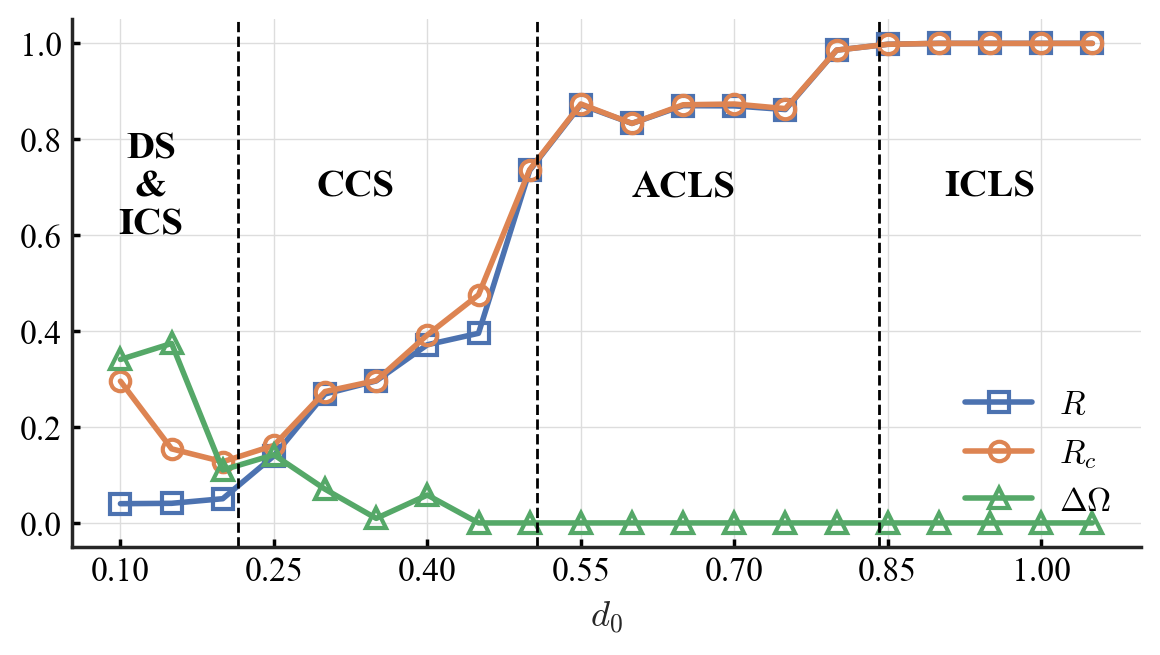

In [64]:
fig, axs = plt.subplots(1, 1, figsize=(6, 3.5))
# ax1, ax2 = axs.flatten()
ax1 = axs

mks = 7
mkfc = (0,0,1,0)

lookLambdaValue = 0.045
plotLine1 = maps1.loc[lookLambdaValue].copy()
plotLine2 = maps2.loc[lookLambdaValue].copy()
plotLine3 = maps3.loc[lookLambdaValue].copy()
plotLine1.iloc[-3] = plotLine1.iloc[-4]
plotLine2.iloc[-3] = plotLine2.iloc[-4]

ax1.plot(maps1.columns, plotLine1, label=r"$R$", marker='s', lw=2, markerfacecolor=mkfc, markeredgecolor="C0", markersize=mks, markeredgewidth=1.5)
ax1.plot(maps2.columns, plotLine2, label=r"$R_c$", marker='o', lw=2, markerfacecolor=mkfc, markeredgecolor="C1", markersize=mks, markeredgewidth=1.5)
ax1.plot(maps3.columns, plotLine3, label=r"$\Delta\Omega$", marker='^', lw=2, markerfacecolor=mkfc, markeredgecolor="C2", markersize=mks, markeredgewidth=1.5)
ax1.set_xlabel(r"$d_0$", fontweight="bold")
# ax1.set_title("(a)", loc="left", fontweight="bold", fontsize=16)
ax1.set_xticks(np.round(distanceDs, 2)[np.arange(len(distanceDs), step=3)])
ax1.axvline(x=0.21497429, color="black", linestyle="--", lw=1)
ax1.axvline(x=0.50678498, color="black", linestyle="--", lw=1)
ax1.axvline(x=0.84104417, color="black", linestyle="--", lw=1)
fontsize = 14
ax1.text(0.13, 0.7, "DS\n&\nICS", fontsize=fontsize, fontweight="bold", ha="center", va="center")
ax1.text(0.33, 0.7, "CCS", fontsize=fontsize, fontweight="bold", ha="center", va="center")
ax1.text(0.65, 0.7, "ACLS", fontsize=fontsize, fontweight="bold", ha="center", va="center")
ax1.text(0.95, 0.7, "ICLS", fontsize=fontsize, fontweight="bold", ha="center", va="center")
ax1.legend(loc="lower right", fontsize=12, frameon=False)

for ax in [axs]:
    # ax.set_ylabel("Order Parameters")
    # ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.tick_params(direction='in', length=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(True)
    ax.set_ylim(-0.05, 1.05)
    

plt.tight_layout()
# folderPath = "./PJT_C_Fig"
folderPath = "../../c-doc/[PJT_C] Chiral2/figs"
plt.savefig(f"{folderPath}/monoOpPlot.pdf", bbox_inches="tight", dpi=300)

In [71]:
lambda_c1(0.13125017), lambda_c2(0.55031009), lambda_c3(1.03006454)

(0.11999999918549395, 0.030000000427781007, 0.029999999925937007)

In [22]:
# 求解lambda_c1等于0.02时的d0
import scipy.optimize as opt

def func(d0):
    return lambda_c1(d0) - 0.035

d0 = opt.fsolve(func, 0.2)
d0

array([0.24401265])

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


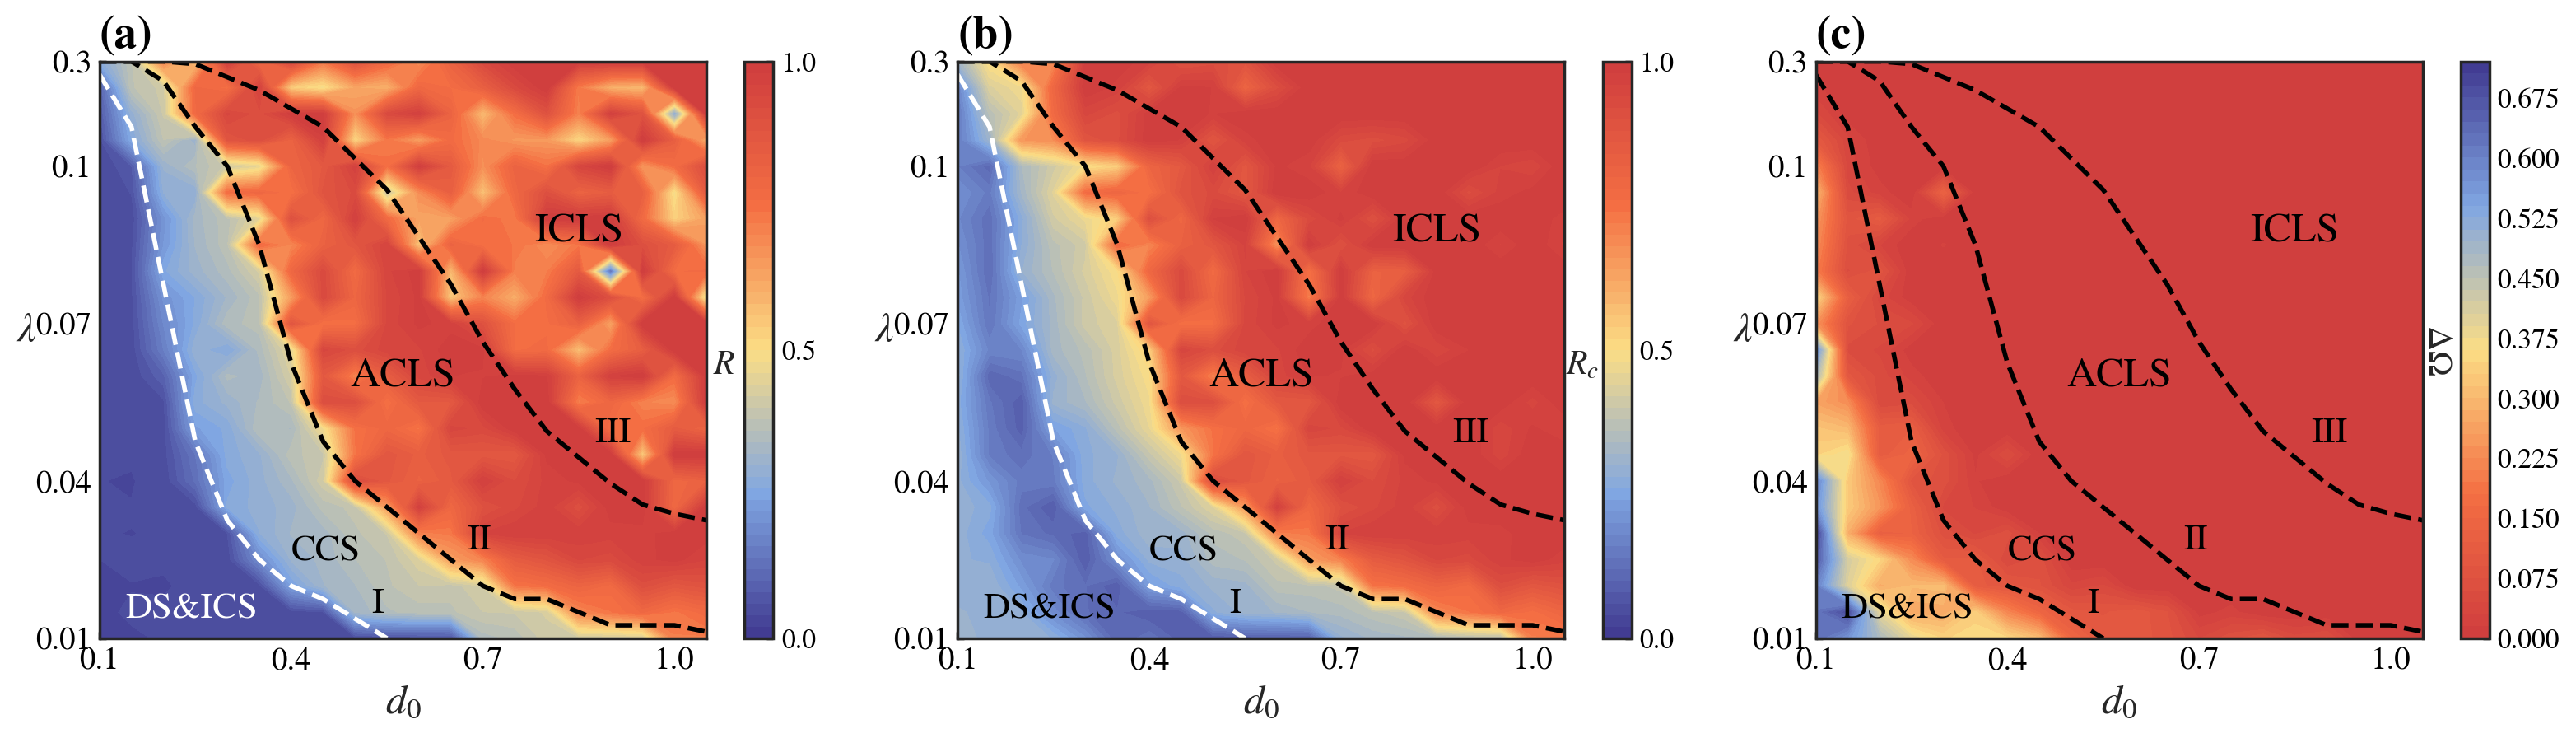

In [6]:
sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
fig, ax = plt.subplots(1, 3, figsize=(16, 4.7))
colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

level = 50
stdMaps1 = maps1.copy()
stdMaps1.iloc[0, 0] = 0
cf1 = ax[0].contourf(
    stdMaps1, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
ax[0].contourf(
    maps1, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
cbar1 = plt.colorbar(cf1, ax=ax[0], ticks=[0, 0.5, 1])
cbar1.set_label(r"$R$", fontsize=15, rotation=0, labelpad=-40)

stdMaps2 = maps2.copy()
stdMaps2.iloc[0, 0] = 0
cf2 = ax[1].contourf(
    stdMaps2, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
ax[1].contourf(
    maps2, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
cbar2 = plt.colorbar(cf2, ax=ax[1], ticks=[0, 0.5, 1])
cbar2.ax.set_yticklabels(['0.0', '0.5', '1.0'])
cbar2.set_label(r"$R_c$", fontsize=15, rotation=0, labelpad=-40)

cf3 = ax[2].contourf(
    maps3, levels=level, 
    cmap=cmap_r,
)
cbar3 = plt.colorbar(cf3, ax=ax[2])
cbar3.set_label(r"$\Delta\Omega$", fontsize=15, rotation=-90, labelpad=-47)

mapColors1 = ["white", "white", "black"]
mapColors2 = ["white", "black", "black"]
for i in range(3):
    ax[i].tick_params(direction='in', length=3)
    ax[i].set_xticklabels(ax[i].get_xticks(), fontsize=14)
    ax[i].set_yticklabels(ax[i].get_yticks(), fontsize=14)
    ax[i].set_xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
    ax[i].set_yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs])
    ax[i].set_xlabel(r"$d_0$", fontsize=18)
    ax[i].set_ylabel(r"$\lambda$", rotation=0, fontsize=18)
    ax[i].set_title(f"({chr(97 + i)})", loc="left", 
                    fontdict={"fontsize": 20, "weight": "bold"})
    # ax[i].plot(funcIdxs[lambda_c0][:4], label=r"$\lambda_{c1}(d_0)$",
    #            linestyle="--", color=mapColors1[i], lw=2, zorder = 2)
    ax[i].plot(line1[:10], label=r"$\lambda_{c1}(d_0)$",
               linestyle="--", color=mapColors1[i], lw=2, zorder = 2)
    ax[i].plot(np.arange(maps.shape[1]), line2, label=r"$\lambda_{c2}(d_0)$",
               linestyle="--", color="black", lw=2, zorder=2)
    ax[i].plot(np.arange(maps.shape[1]), line3, label=r"$\lambda_{c3}(d_0)$",
               linestyle="--", color="black", lw=2, zorder=2)
    ax[i].text(0.8, 0.8, "DS&ICS", fontsize=16, color=mapColors2[i])
    ax[i].text(6, 3, "CCS", fontsize=16, color="black")
    ax[i].text(9.5, 10, "ACLS", ha="center", va="center", fontsize=18, color="black")
    ax[i].text(15, 15.5, "ICLS", ha="center", va="center", fontsize=18, color="black")
    ax[i].text(8.5, 1, "I", fontsize=16, color="black")
    ax[i].text(11.5, 3.4, "II", fontsize=16, color="black")
    ax[i].text(15.5, 7.5, "III", fontsize=16, color="black")
    ax[i].set_xlim(0, maps.shape[1] - 1)
    ax[i].set_ylim(0, maps.shape[0] - 1)

for cbar in [cbar1, cbar2, cbar3]:
    cbar.ax.tick_params(direction='in', length=3)

plt.tight_layout()
folderPath = "./PJT_C_Fig"
# folderPath = "../../c-doc/[PJT_C] Chiral2/figs"
plt.savefig(f"{folderPath}/monoOrderParam.png", bbox_inches="tight", dpi=300)

In [49]:
def plot_last_state(key: str, ax: plt.Axes = None, loadModel: bool = False, index: int = -1,
                    showTicks: bool = False, tickSize: int = 16, randomSeed: int = 10):
    if ax is None:

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    if loadModel:
        l, d0 = key.split("_")
        l, d0 = float(l), float(d0)
        model = SingleDistribution(l, d0, speedV, savePath="./data", randomSeed=randomSeed)
        sa = StateAnalysis(model, showTqdm=False)
        singlePositionX, singlePhaseTheta, _ = sa.get_state(index=index)
    else:
        model = SingleDistribution(
            strengthLambda=0, distanceD0=0, boundaryLength=10,
            savePath="./data", distributType="uniform", randomSeed=10, overWrite=True)
        singlePositionX = positionX[key]
        singlePhaseTheta = phaseTheta[key]
    omegaTheta = model.omegaTheta

    ax.quiver(
        singlePositionX[:, 0], singlePositionX[:, 1],
        np.cos(singlePhaseTheta[:]), np.sin(singlePhaseTheta[:]), 
        color=[cmap(i) for i in (omegaTheta - 1) / 2], alpha=1,
        scale=23, width=0.005
    )

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    if showTicks:
        ax.set_xticks([0, 10])
        ax.set_yticks([0, 10])
        ax.set_xlabel(r"$x_i$", fontsize=tickSize)
        ax.set_ylabel(r"$y_i$", fontsize=tickSize, rotation=0)
        ax.set_xticklabels(ax.get_xticks(), fontsize=tickSize)
        ax.set_yticklabels(ax.get_yticks(), fontsize=tickSize)
        # 拉近label与坐标轴的距离
        ax.xaxis.labelpad = -20
        ax.yaxis.labelpad = -10
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    ax.grid(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    plt.tick_params(direction='in', length=3)

def plot_Aij(model: SpatialGroups, ax: plt.Axes = None, clusterBaseCenter: bool = True):
    if ax is None:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)
    sa = StateAnalysis(model)
    lastPositionX, lastPhaseTheta, lastPointTheta = sa.get_state(-1)
    if clusterBaseCenter:
        centers = sa._calc_centers(
            lastPositionX, lastPhaseTheta, lastPointTheta, speedV, 0.01
        )
        classes = sa._calc_classes(
            centers, 0.3, sa._adj_distance(centers, centers[:, np.newaxis], 10, 5)
        )
    else:
        classes = sa._calc_classes(
            lastPositionX, 0.3, sa._adj_distance(lastPositionX, lastPositionX[:, np.newaxis], 10, 5)
        )
    drifters = list()
    preAjdClasses = dict()
    classCounts = 0
    for classIdx in range(len(classes)):
        if len(classes[classIdx]) < 10:
            drifters.extend(classes[classIdx])
        else:
            preAjdClasses[classCounts] = classes[classIdx]
            classCounts += 1
    # sort sub classes
    deltaX = SpatialGroups._delta_x(lastPositionX, lastPositionX[:, np.newaxis], 10, 5)
    distances = SpatialGroups.distance_x(deltaX)
    ajdClasses = dict()
    for classIdx in preAjdClasses:
        ocsIdx = preAjdClasses[classIdx]
        classDistances = distances[ocsIdx][:, ocsIdx]
        sortedOcsIdx = [ocsIdx[0]]
        for oscIdx in range(len(ocsIdx) - 1):
            closestIdx = np.argsort(classDistances[oscIdx])[1]
            sortedOcsIdx.append(ocsIdx[closestIdx])
        ajdClasses[classIdx] = sortedOcsIdx

    idxs = np.concatenate(list(ajdClasses.values()) + [drifters]).astype(np.int32)
    soredPosition = lastPositionX[idxs]
    deltaX = SpatialGroups._delta_x(soredPosition, soredPosition[:, np.newaxis], 10, 5)
    distances = SpatialGroups.distance_x(deltaX)
    Aij2 = distances <= model.distanceD0
    clusterColorsMap = {str(i): cmap(i / len(ajdClasses) * 0.75 + 0.25) for i in range(len(ajdClasses))}
    clusterColorsKeys = list(clusterColorsMap.keys())
    adjClassColors = [
        [clusterColorsKeys[i]] * len(ajdClasses[i]) 
        for i in ajdClasses
    ] + [["gray"] * len(drifters)]
    colors = list()
    for i in range(len(adjClassColors)):
        colors.extend(adjClassColors[i])
    colors = np.array([colors] * model.agentsNum).T
    lowerRight = np.tril(colors)
    for i in range(model.agentsNum):
        for j in range(i+1, model.agentsNum):
            colors[i, j] = lowerRight[j, i]
    colors = colors.T
    for idx, row in enumerate(Aij2):
        isTrue = np.where(row)[0]
        subColors = colors[idx, isTrue].tolist()
        for subCIdx, subC in enumerate(subColors):
            if subC in clusterColorsMap:
                subColors[subCIdx] = clusterColorsMap[subC]
        ax.scatter(np.ones_like(isTrue) * idx, isTrue, color=subColors, s=1, alpha=0.6)

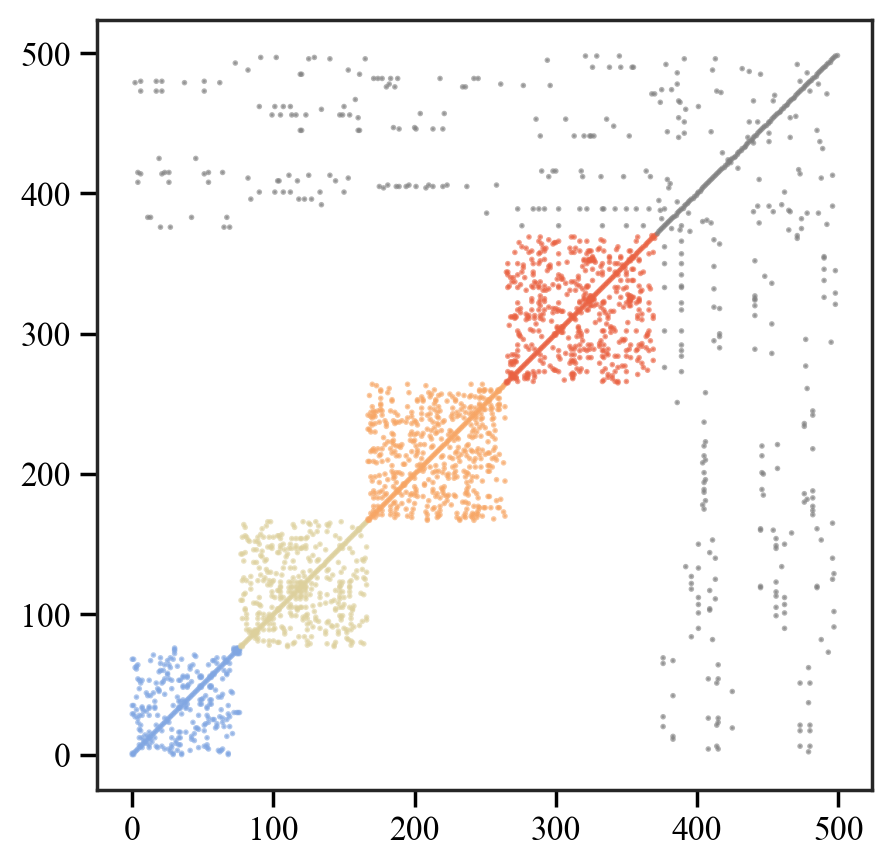

In [50]:
plot_Aij(SingleDistribution(strengthLambda=0.01, distanceD0=0.35, savePath="./data"))

d:\anaconda3\envs\py37\lib\site-packages\matplotlib\cbook\__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


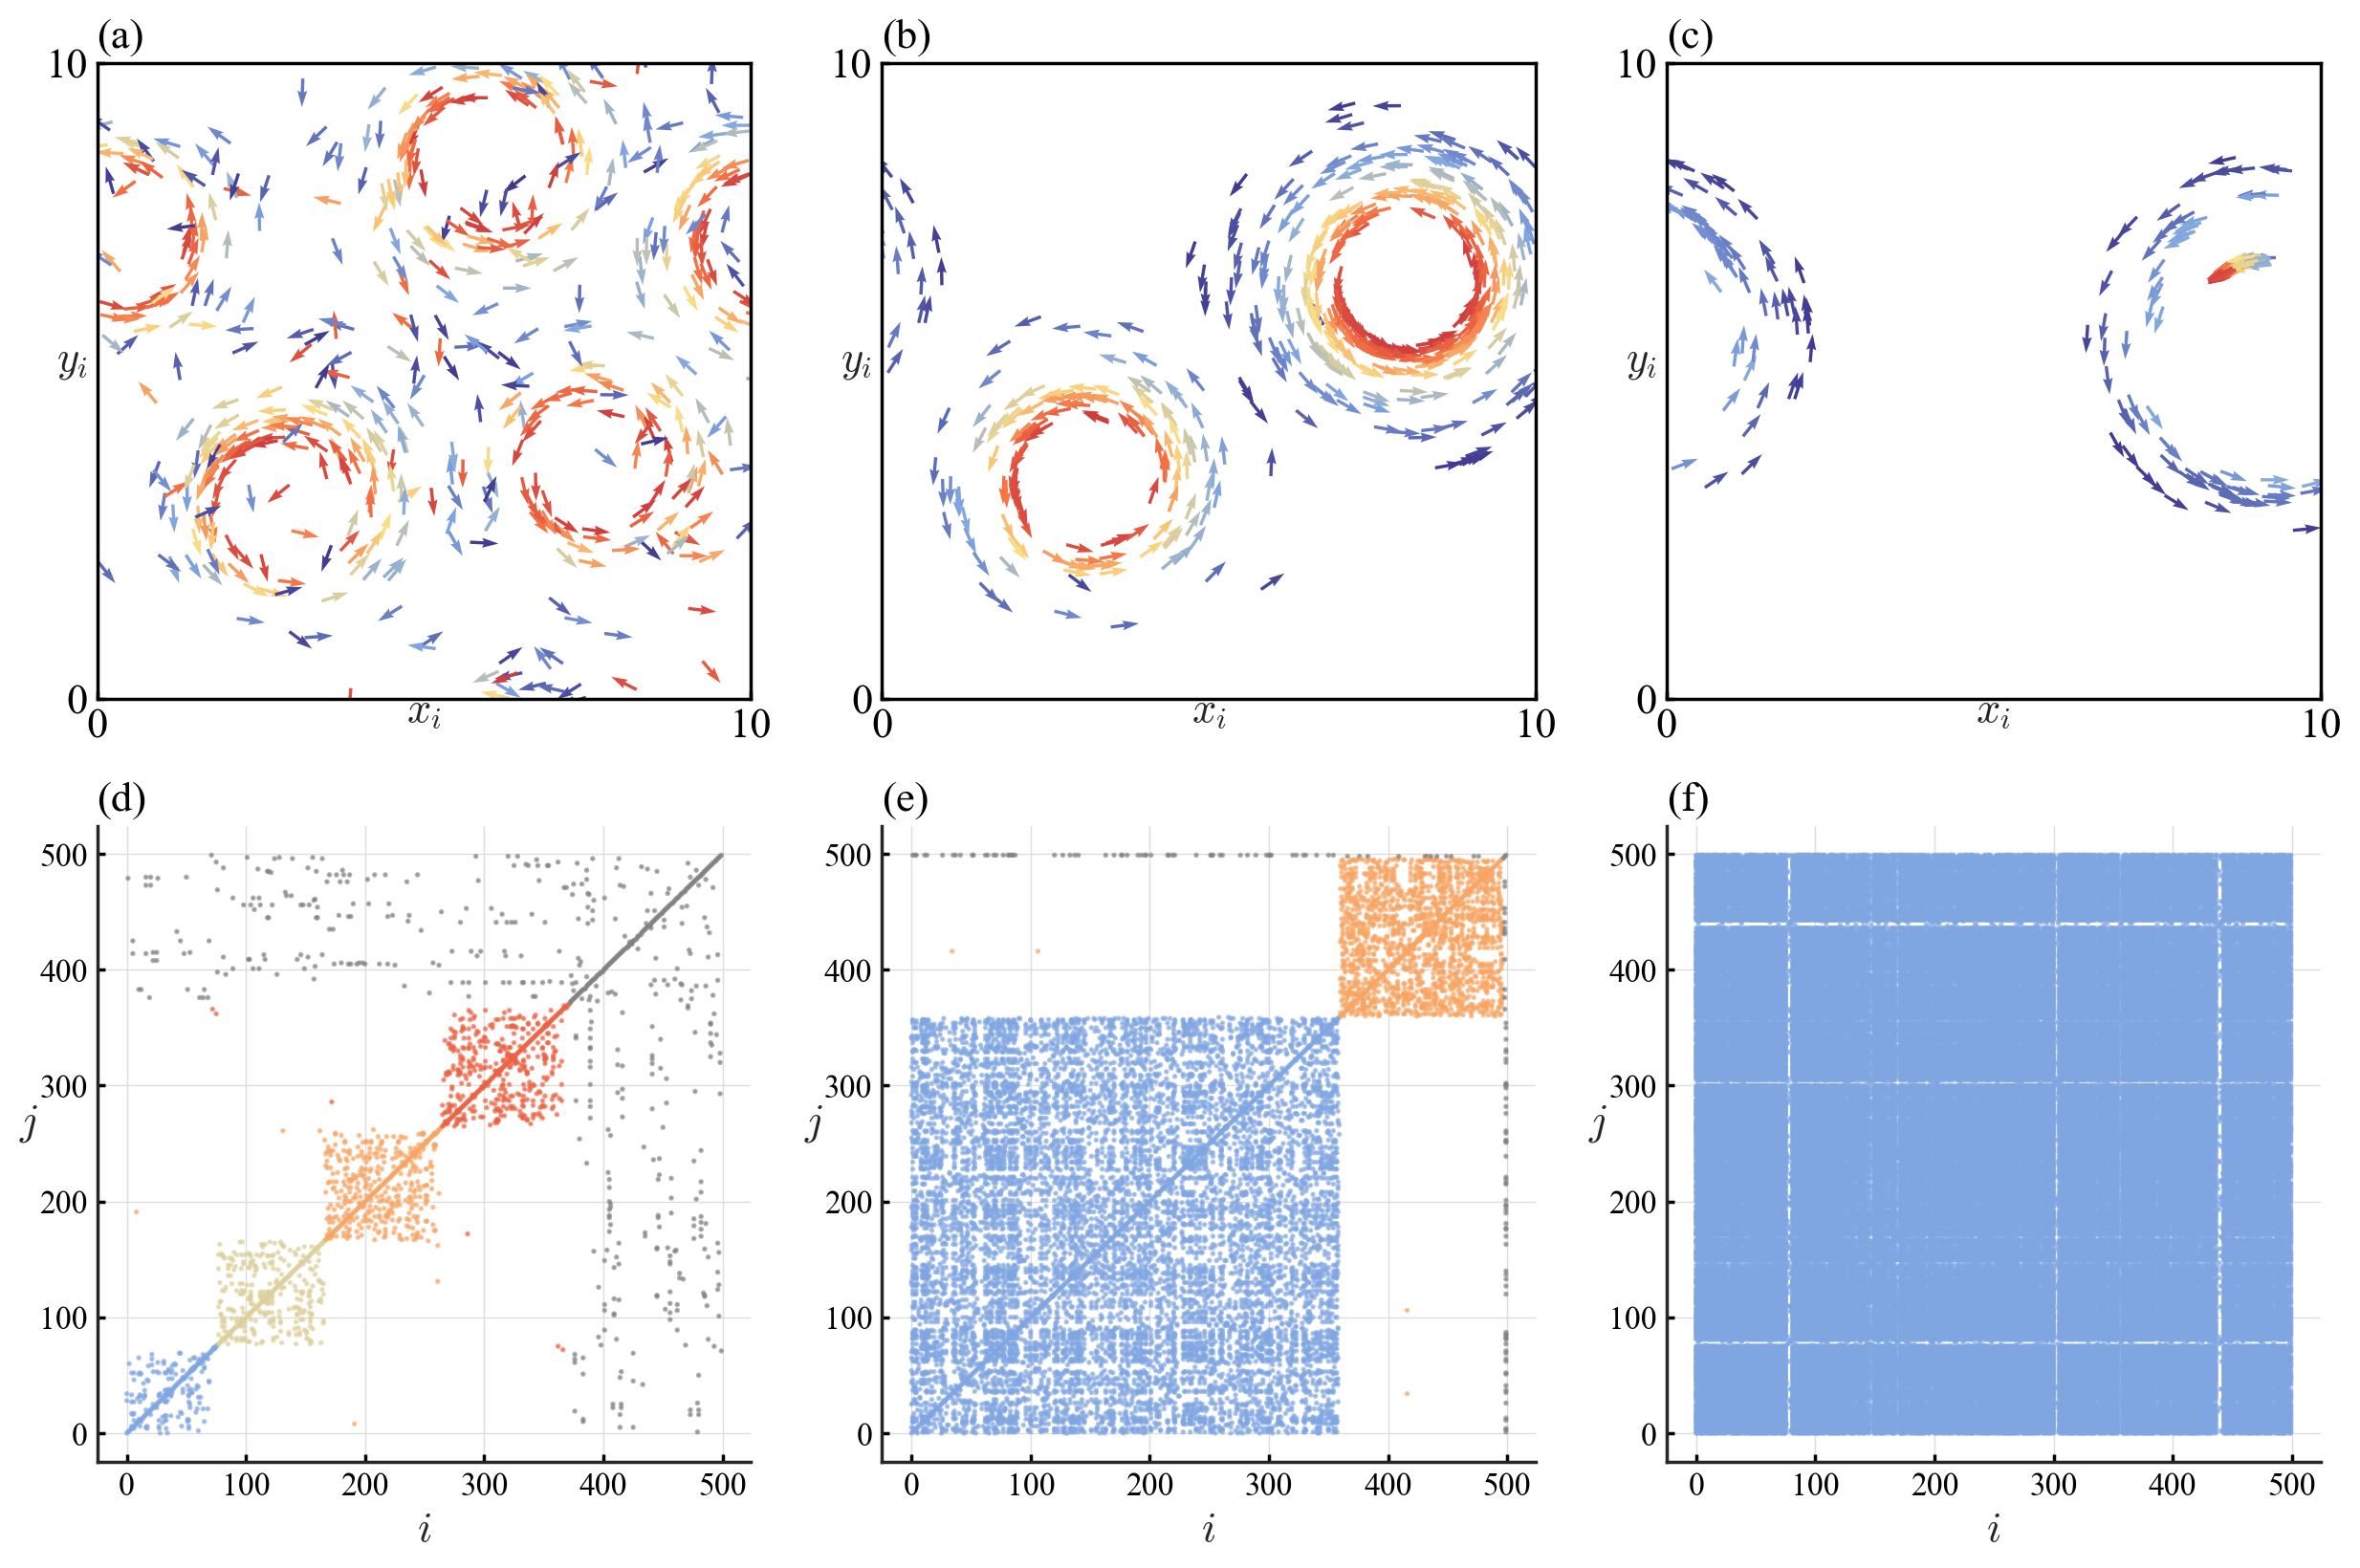

In [66]:
fig, axs = plt.subplots(2, 3, figsize=(15, 9.5))
ax1, ax2, ax3, ax4, ax5, ax6 = axs.flatten()

plot_last_state(f"{0.01:.3f}_{0.35:.2f}", ax1, loadModel=True, index=-1, showTicks=True)
plot_last_state(f"{0.01:.3f}_{0.65:.2f}", ax2, loadModel=True, index=-1, showTicks=True)
plot_last_state(f"{0.01:.3f}_{1.05:.2f}", ax3, loadModel=True, index=-1, showTicks=True)
plot_Aij(SingleDistribution(strengthLambda=0.01, distanceD0=0.35, savePath="./data"), ax4)
plot_Aij(SingleDistribution(strengthLambda=0.01, distanceD0=0.65, savePath="./data"), ax5)
plot_Aij(SingleDistribution(strengthLambda=0.01, distanceD0=1.05, savePath="./data"), ax6)

for axIdx, ax in enumerate(axs.flatten()):
    ax.set_title(f"({chr(97 + axIdx)})", loc="left", fontsize=16)
    ax.tick_params(direction='in', length=3)

for ax in [ax4, ax5, ax6]:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xlabel(r"$i$", fontsize=16)
    ax.set_ylabel(r"$j$", fontsize=16, rotation=0)
    ax.grid(True)

# folderPath = "./PJT_C_Fig"
folderPath = "../../c-doc/[PJT_C] Chiral2/figs"
plt.savefig(f"{folderPath}/mono_CS_Aij.png", bbox_inches="tight", dpi=300)
# plt.savefig(f"{folderPath}/mono_CS_Aij.pdf", bbox_inches="tight")

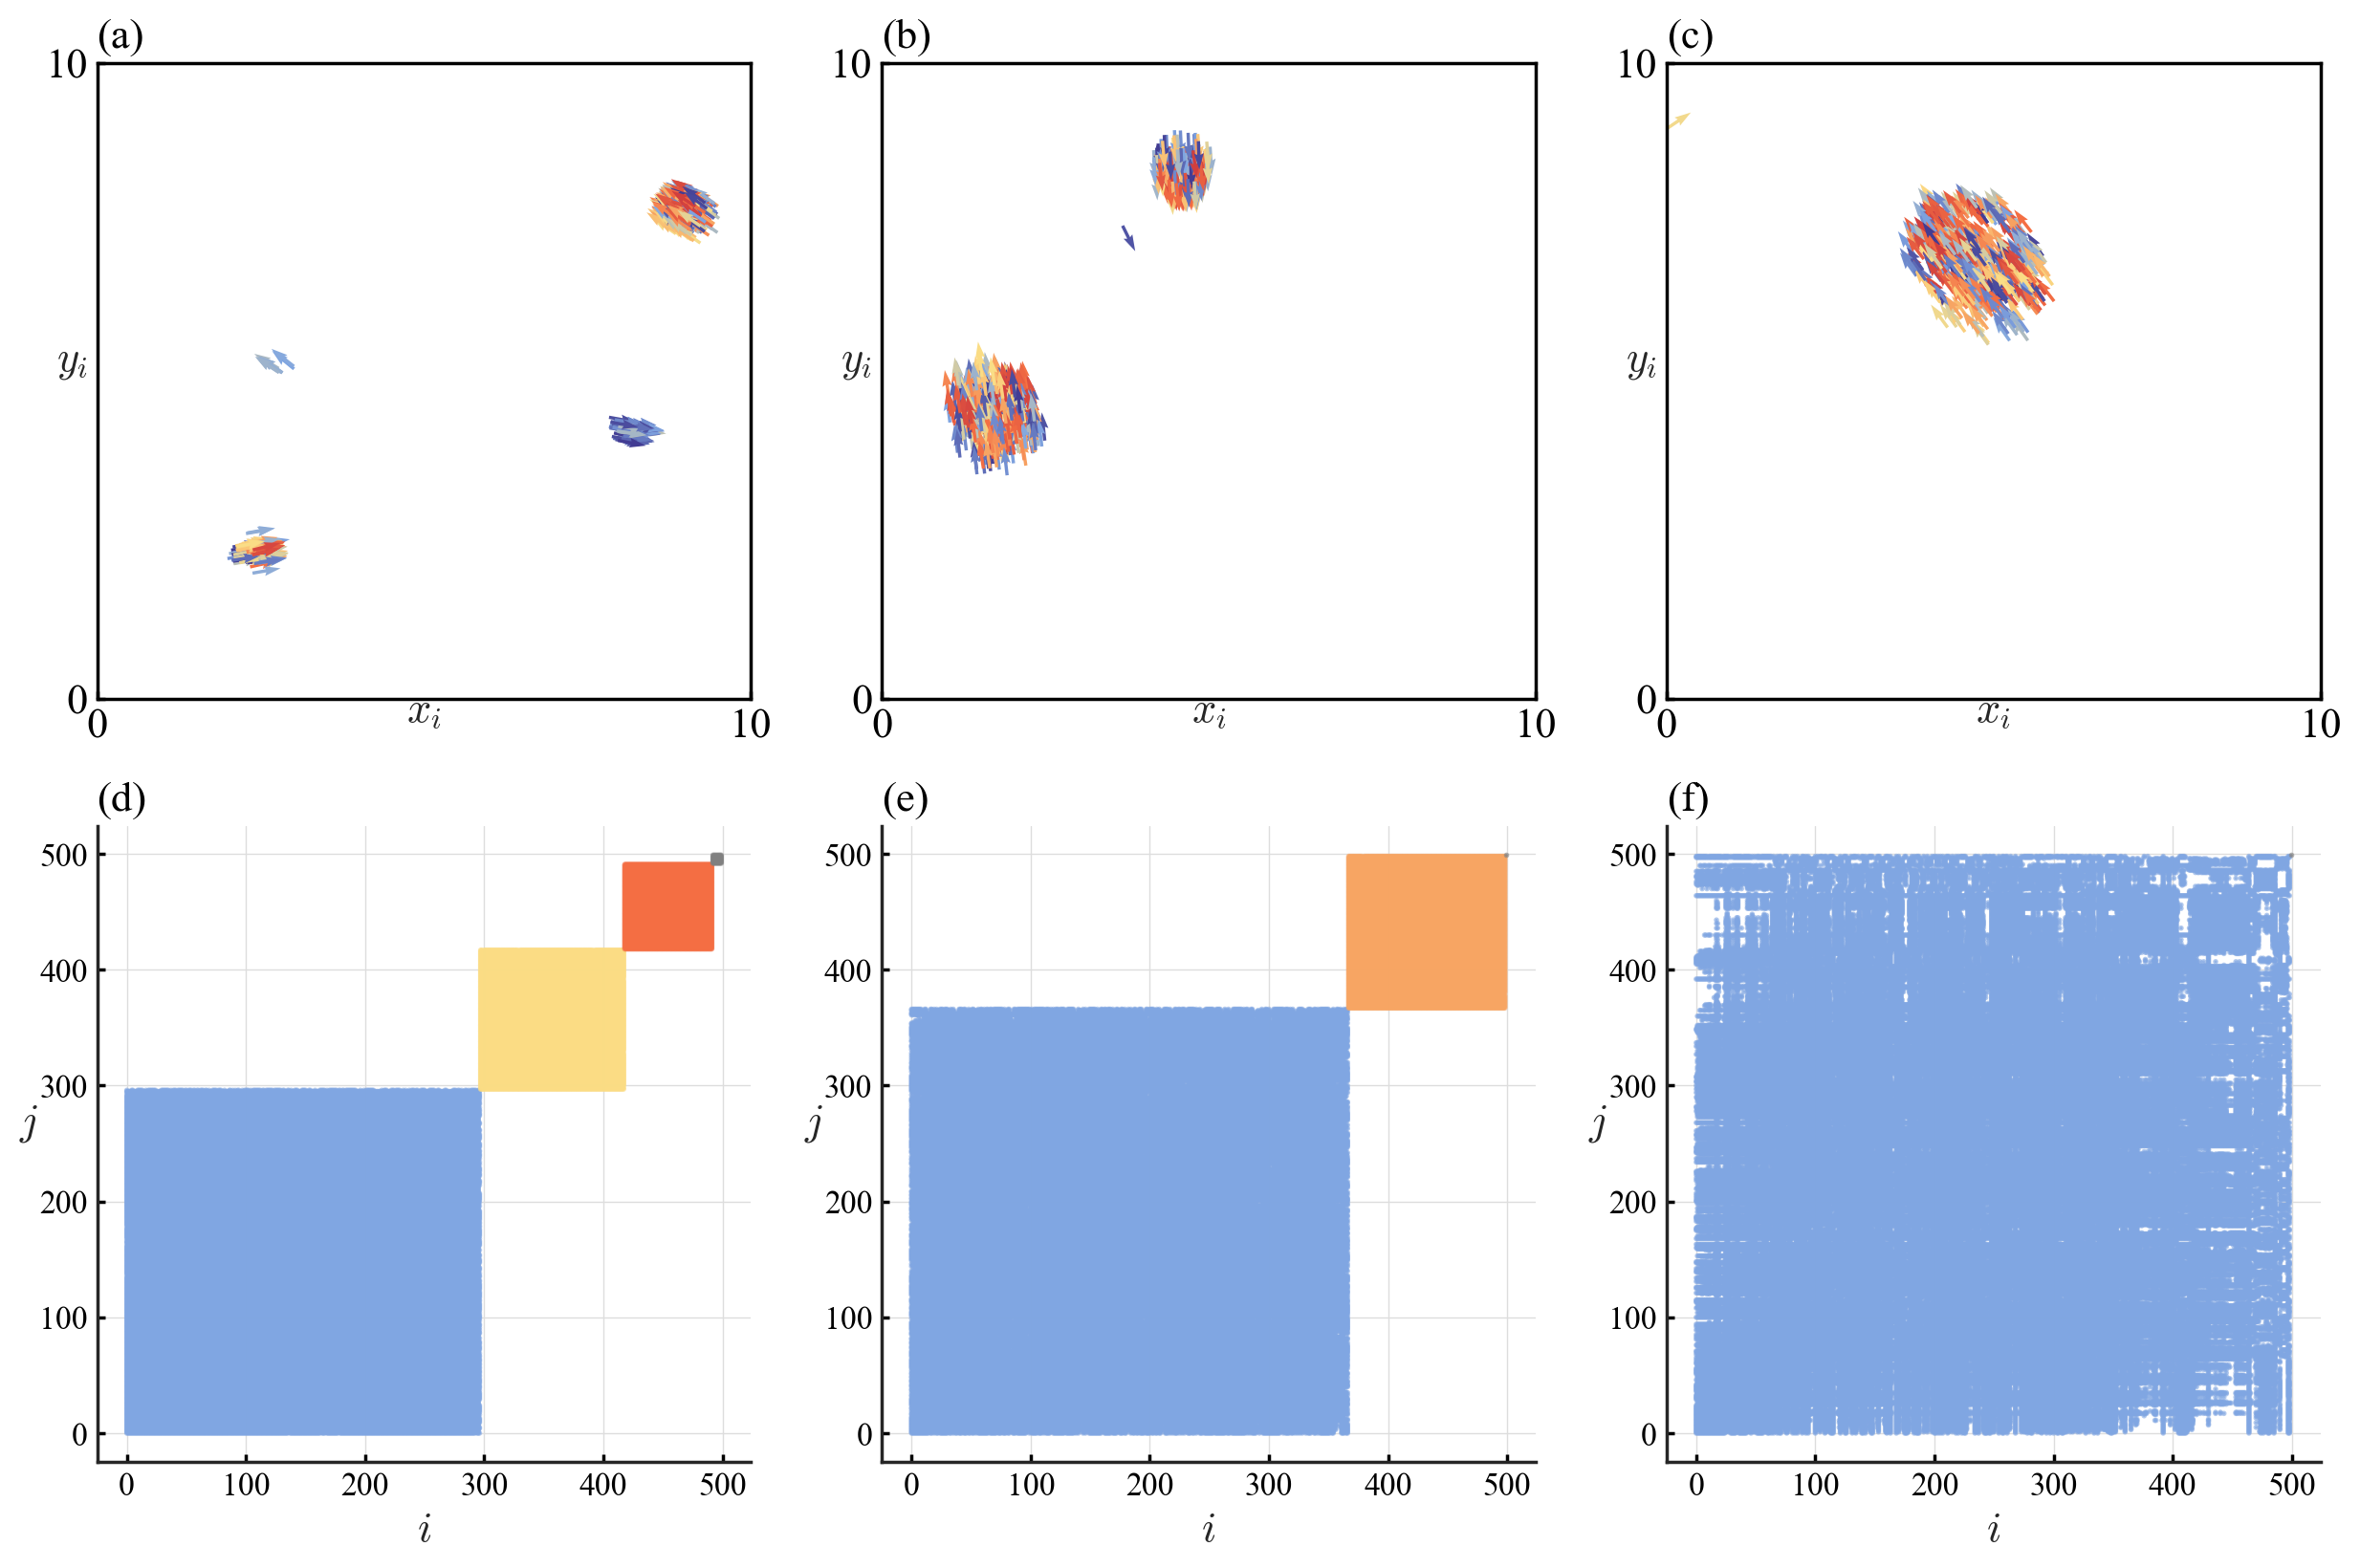

In [65]:
fig, axs = plt.subplots(2, 3, figsize=(15, 9.5))
ax1, ax2, ax3, ax4, ax5, ax6 = axs.flatten()

plot_last_state(f"{0.15:.3f}_{0.5:.2f}", ax1, loadModel=True, index=-1, showTicks=True)
plot_last_state(f"{0.15:.3f}_{0.85:.2f}", ax2, loadModel=True, index=-1, showTicks=True)
plot_last_state(f"{0.15:.3f}_{0.95:.2f}", ax3, loadModel=True, index=-1, showTicks=True)
plot_Aij(SingleDistribution(strengthLambda=0.15, distanceD0=0.5, savePath="./data"), ax4, clusterBaseCenter=False)
plot_Aij(SingleDistribution(strengthLambda=0.15, distanceD0=0.85, savePath="./data"), ax5, clusterBaseCenter=False)
plot_Aij(SingleDistribution(strengthLambda=0.15, distanceD0=0.95, savePath="./data"), ax6, clusterBaseCenter=False)

for axIdx, ax in enumerate(axs.flatten()):
    ax.set_title(f"({chr(97 + axIdx)})", loc="left", fontsize=16)
    ax.tick_params(direction='in', length=3)

for ax in [ax4, ax5, ax6]:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xlabel(r"$i$", fontsize=16)
    ax.set_ylabel(r"$j$", fontsize=16, rotation=0)
    ax.grid(True)

# folderPath = "./PJT_C_Fig"
folderPath = "../../c-doc/[PJT_C] Chiral2/figs"
plt.savefig(f"{folderPath}/mono_CLS_Aij.png", bbox_inches="tight", dpi=300)
# plt.savefig(f"{folderPath}/mono_CLS_Aij.pdf", bbox_inches="tight")

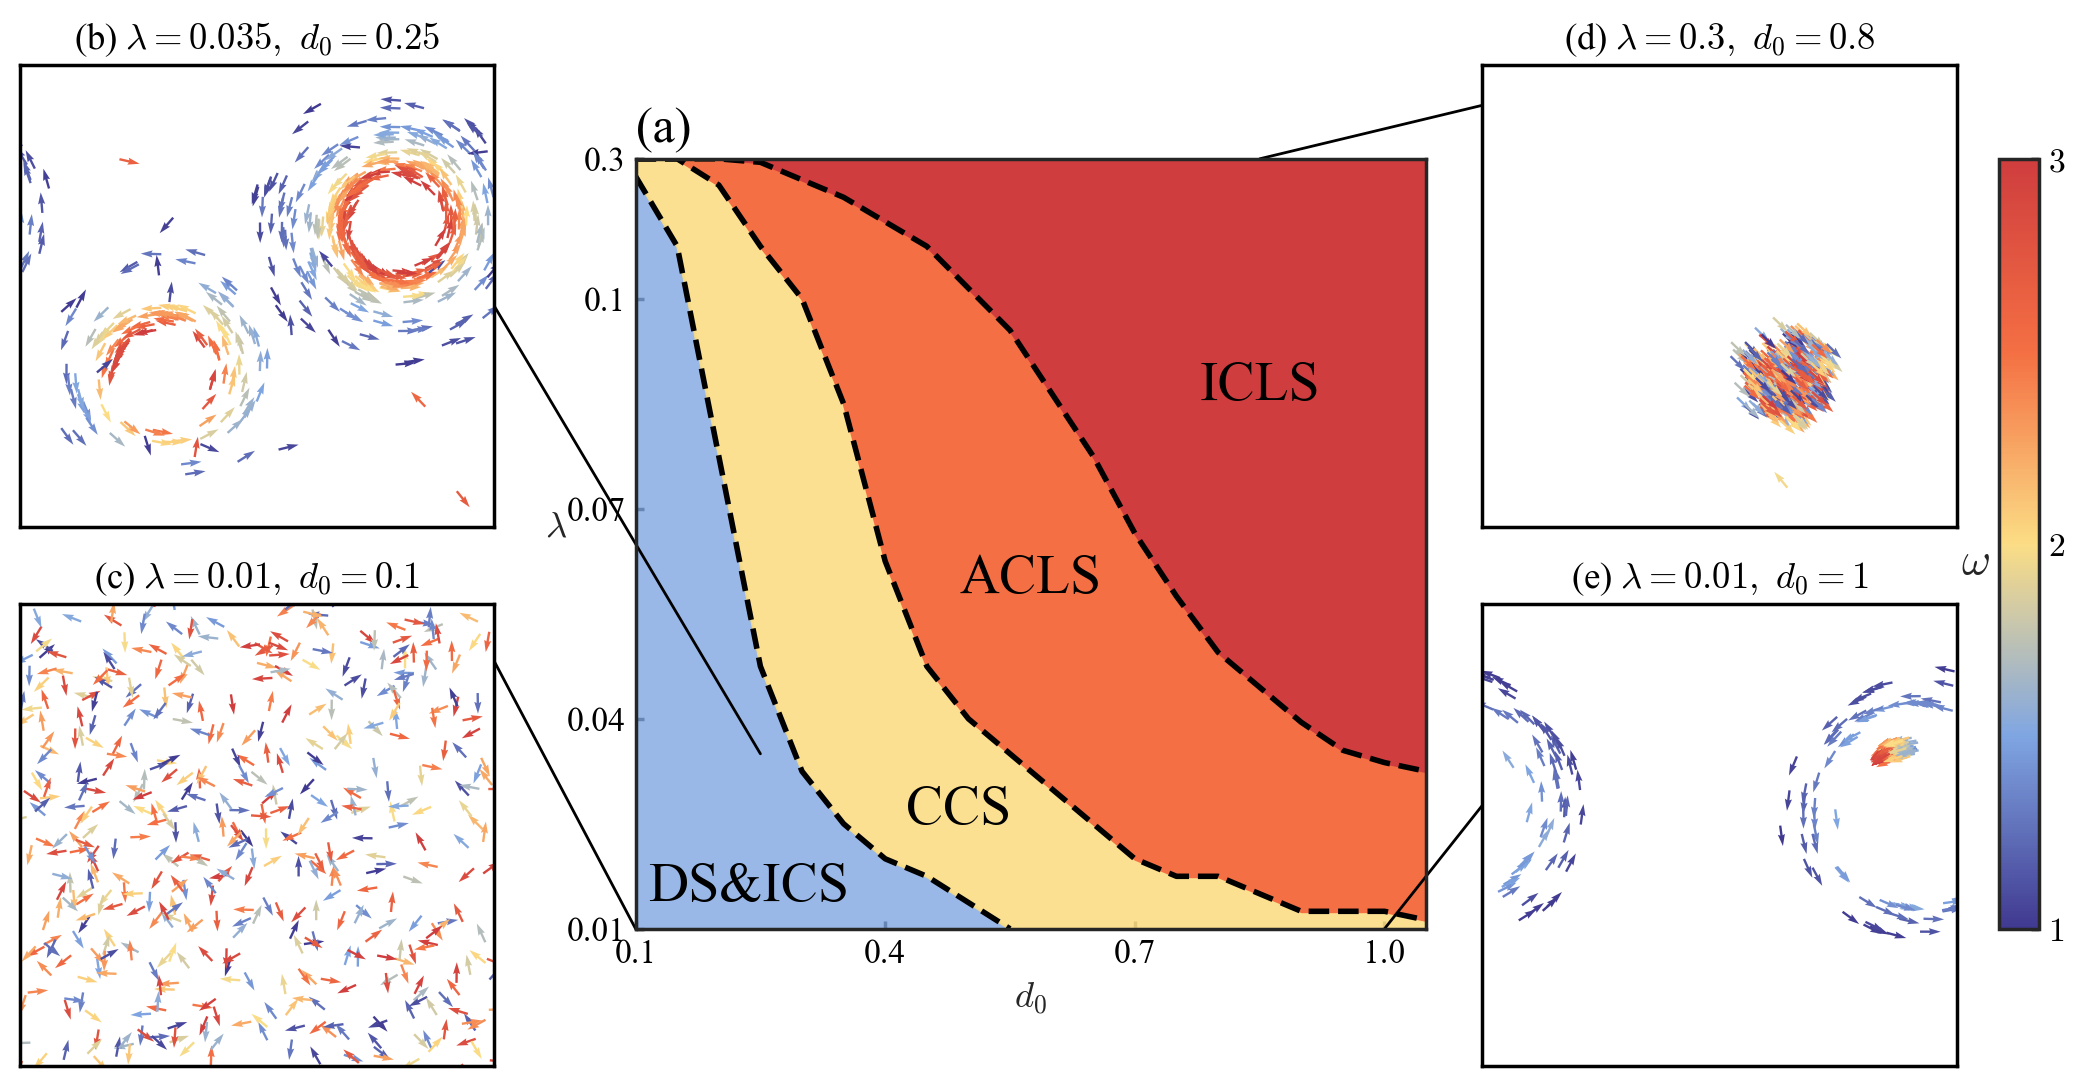

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5.1, 5))
maps1 = pd.read_excel("L5SingleDistributeR.xlsx", index_col=0)
# plt.contourf(maps1, levels=50, cmap=cmap)
# plt.plot(funcIdxs[lambda_c0][:4], 
#          linestyle="--", color="black", lw=2, zorder=2)
plt.plot(line1[:10],
         linestyle="--", color="black", lw=2, zorder=2)
plt.plot(np.arange(maps.shape[1]), line2,
         linestyle="--", color="black", lw=2, zorder = 2)
plt.plot(np.arange(maps.shape[1]), line3,
         linestyle="--", color="black", lw=2, zorder = 2)
plt.fill_between(
    np.arange(maps.shape[1]), 0, line1, alpha=0.8, color="#80A6E2"
)
plt.fill_between(
    np.arange(maps.shape[1]), line1, line2, alpha=0.9, color="#FBDD85"
)
plt.fill_between(
    np.arange(maps.shape[1]), line2, line3, alpha=1, color="#F46F43"
)
plt.fill_between(
    np.arange(maps.shape[1]), line3, len(rangeLambdas) - 1, alpha=1, color="#CF3D3E"
)

# ax.plot([2, 1.5], [-1.5, 0], clip_on=False, color="black", lw=1)  # Disorder Text
ax.plot([-4, 0], [9, 0], clip_on=False, color="black", lw=1)  # Disorder
ax.plot([-4, 3], [19, 5], clip_on=False, color="black", lw=1)  # ICS
ax.plot([22, 18], [6, 0], clip_on=False, color="black", lw=1)  # CCS
ax.plot([15, 22], [22, 24], clip_on=False, color="black", lw=1)

# plt.text(2, 3, "Circling State", fontsize=20, color="black")
plt.text(0.3, 0.8, "DS&ICS", fontsize=20, color="black")
plt.text(6.5, 3, "CCS", fontsize=20, color="black")
plt.text(9.5, 10, "ACLS", ha="center", va="center", fontsize=20, color="black")
plt.text(15, 15.5, "ICLS", ha="center", va="center", fontsize=20, color="black")

plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
plt.yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs])
plt.tick_params(direction='in', length=3)

plt.ylim(0, maps.shape[0] - 1)
plt.xlim(0, maps.shape[1] - 1)

plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$", rotation=0)
plt.grid(False)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

axICS = inset_axes(ax, width="40%", height="40%", loc='lower left',
                    bbox_to_anchor=(-0.8, 0.5, 1.5, 1.5),
                    bbox_transform=ax.transAxes)

plot_last_state(f"{0.035:.3f}_{0.25:.2f}", ax=axICS)
axICS.set_title(r"(b) $\lambda=0.035,\ d_0=0.25$")

axDisorder = inset_axes(ax, width="40%", height="40%", loc='lower left',
                      bbox_to_anchor=(-0.8, -0.2, 1.5, 1.5),
                      bbox_transform=ax.transAxes)
plot_last_state(f"{0.01:.3f}_{0.1:.2f}", ax=axDisorder)
axDisorder.set_title(r"(c) $\lambda=0.01,\ d_0=0.1$")

axQuickSync = inset_axes(ax, width="40%", height="40%", loc='lower left',
                         bbox_to_anchor=(1.05, 0.5, 1.5, 1.5),
                         bbox_transform=ax.transAxes)
plot_last_state(f"{0.3:.3f}_{0.8:.2f}", ax=axQuickSync)
axQuickSync.set_title(r"(d) $\lambda=0.3,\ d_0=0.8$")

axDRCS = inset_axes(ax, width="40%", height="40%", loc='lower left',
                      bbox_to_anchor=(1.05, -0.2, 1.5, 1.5),
                      bbox_transform=ax.transAxes)
plot_last_state(f"{0.01:.3f}_{1:.2f}", ax=axDRCS)
axDRCS.set_title(r"(e) $\lambda=0.01,\ d_0=1$")

colorbarAx = inset_axes(ax, width="5%", height="100%", loc='center',
                        bbox_to_anchor=(1.25, 0, 1, 1),
                        bbox_transform=ax.transAxes)
sca = ax.scatter(-np.ones_like(omegaTheta), -np.ones_like(omegaTheta), 
           c=np.linspace(1, 3, len(omegaTheta)), cmap=cmap, s=100)
cbar = plt.colorbar(sca, cax=colorbarAx, ticks=[1, 2, 3])
cbar.ax.set_ylim(1, 3)
cbar.ax.set_yticklabels(['$1$', '$2$', '$3$'])
cbar.set_label(r"$\omega$", fontsize=16, rotation=0)
cbar.ax.yaxis.set_label_coords(-0.6, 0.5)
cbar.ax.tick_params(direction='in', length=3)
ax.set_title(r"(a)", loc="left", fontsize=18)
# 保存为矢量图
folderPath = "./PJT_C_Fig"
# folderPath = "../../c-doc/[PJT_C] Chiral2/figs"
plt.savefig(f"{folderPath}/monoChiralPhaseDiagram.pdf", bbox_inches="tight")

In [12]:
np.where(distanceDs == distanceDs[2]), np.where(rangeLambdas == rangeLambdas[6])

((array([2], dtype=int64),), (array([6], dtype=int64),))

In [ ]:
# mono-chiral swarmalator
@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - (1 - (phaseTheta - 1) / 2) * 256).astype(np.int32)

rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.01), np.arange(0.1, 0.31, 0.1)
])
distanceDs = np.concatenate([
    np.arange(0.1, 1.1, 0.1)
])

idx = 1

fig = plt.figure(figsize=(len(rangeLambdas) * 4.5, len(distanceDs) * 5))

for l, d0 in tqdm(product(rangeLambdas, distanceDs), total=len(rangeLambdas) * len(distanceDs)):
    
    model = SingleDistribution(
        strengthLambda=l, distanceD0=d0, boundaryLength=10,
        savePath="./data", distributType="uniform", randomSeed=10, overWrite=True)
    ax = plt.subplot(len(rangeLambdas), len(distanceDs), idx)
    
    key = f"{l:.3f}_{d0:.2f}"
    # for i in range(1, 6):
    # try:
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    # except:
    #     continue

    omegaTheta = model.omegaTheta
    plt.quiver(
        lastPositionX[:, 0], lastPositionX[:, 1],
        np.cos(lastPhaseTheta[:]), np.sin(lastPhaseTheta[:]), 
        color=[cmap(i) for i in (omegaTheta - 1) / 2], scale=30, width=0.004
    )
    plt.scatter(lastPositionX[:, 0], lastPositionX[:, 1],
                c=omegaTheta, cmap=new_cmap, alpha=0.8, vmin=1, vmax=3, s=0.01)

    cbar = plt.colorbar(ticks=[1, 2, 3])
    cbar.ax.set_ylim(1, 3)
    cbar.ax.set_yticklabels(['$1$', '$2$', '$3$'])
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)    
    ax.set_title(f"{l:.3f}_{d0:.2f}")
    
    idx += 1

plt.savefig("SingleDistributionBigGraph.png", dpi=200, bbox_inches="tight")
plt.close()

In [108]:
model = SingleDistribution(
        strengthLambda=0.1, distanceD0=0.15, boundaryLength=10, tqdm=True,
        savePath="./data", distributType="uniform", randomSeed=10, overWrite=True) 

In [109]:
model.run(60000)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
savePath = "./data"
mp4Path = "./mp4"

def draw_mp4(model: SingleDistribution):

    targetPath = f"{savePath}/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    shift = 0
    omegaTheta = model.omegaTheta

    def plot_frame(i):
        pbar.update(1)
        positionX = totalPositionX[i]
        phaseTheta = totalPhaseTheta[i]
        fig.clear()
        ax1 = plt.subplot(1, 2, 1)
        ax1.quiver(
            positionX[:, 0], positionX[:, 1],
            np.cos(phaseTheta), np.sin(phaseTheta), 
            color=[cmap(i) for i in (omegaTheta - 1) / 2], alpha=1,
            scale=23, width=0.005
        )
        ax1.set_xlim(0, model.boundaryLength)
        ax1.set_ylim(0, model.boundaryLength)

        ax2 = plt.subplot(1, 2, 2, projection='3d')
        hist, bins = np.histogram(phaseTheta, bins=100, range=(-np.pi, np.pi))
        ax2.plot_surface(
            np.cos(bins[:-1]), np.sin(bins[:-1]), 
            np.array([np.zeros_like(hist), hist]), 
            color='tomato', alpha=0.5, edgecolor="tomato"
        )
        ax2.set_xlabel(r"$\cos(\theta_I)$")
        ax2.set_ylabel(r"$\sin(\theta_I)$")
        ax2.set_zlabel("Count")
        ax2.set_zlim(0, model.agentsNum)

    TNum = 100
    pbar = tqdm(total=TNum)
    fig, ax = plt.subplots(figsize=(11, 5))
    ani = ma.FuncAnimation(fig, plot_frame, frames=np.arange(0, TNum, 1), interval=50, repeat=False)
    ani.save(f"{mp4Path}/{model}.mp4", dpi=150)
    plt.close()

    pbar.close()

In [ ]:
draw_mp4(model)

In [ ]:
targetPath = f"{savePath}/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)

In [ ]:
totalPointTheta

In [ ]:
plt.plot(totalPositionX[:, 3, 0], totalPositionX[:, 3, 1])
plt.xlim(0, 5)
plt.ylim(0, 5)

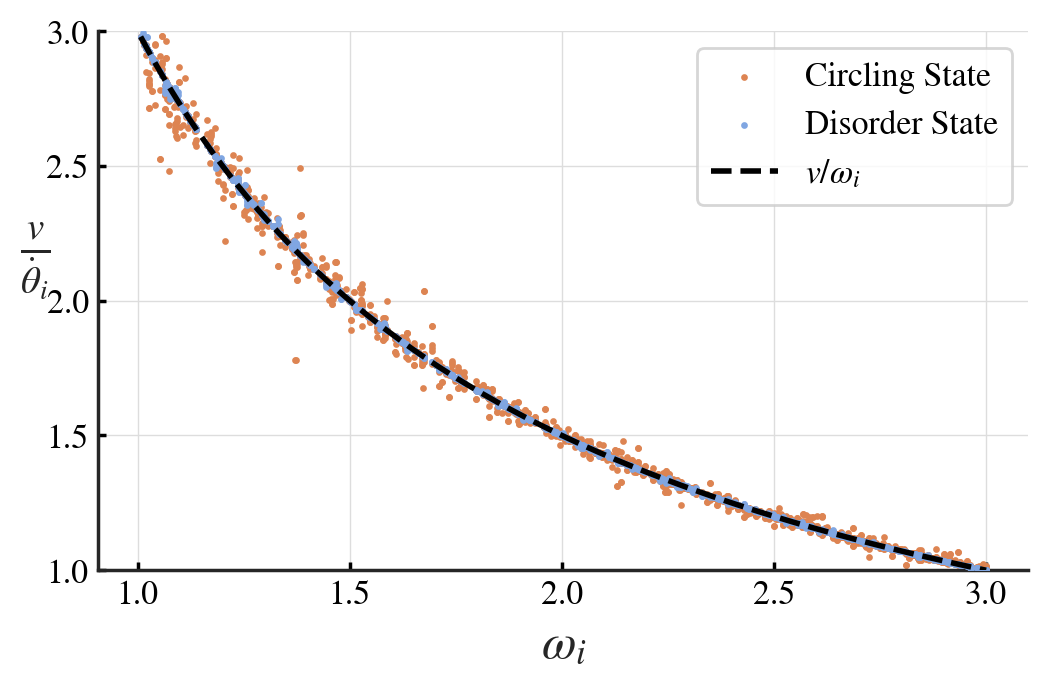

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 3.5))
tickSize = 18

rangeLambdas = np.arange(0.03, 0.05, 0.005)
distanceDs = [0.15]

for rangeLambda in rangeLambdas:
    model = SingleDistribution(strengthLambda=rangeLambda, distanceD0=0.2, boundaryLength=10, 
                               tqdm=False, savePath="./data", randomSeed=10, overWrite=True)
    l, d0 = model.strengthLambda, model.distanceD0
    key = f"{l:.3f}_{d0:.2f}"
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV, dt)
    # positionX, phaseTheta, pointTheta = sa.get_state(-1)
    distances = np.sqrt(np.sum((centers - lastPositionX)**2, axis=1))  # sa.adj_distance(centers, positionX)
    omegaTheta = np.abs(model.omegaTheta)
    sort = np.argsort(omegaTheta)
    omegaTheta, distances = omegaTheta[sort], distances[sort]

    ax1.scatter(omegaTheta, distances, s=2, color="C1", zorder=2)
    if rangeLambda == rangeLambdas[-1]:
        # legend = False
        # ax1.plot(omegaTheta, 3 / omegaTheta, linestyle="--", color="black", lw=1, label="Analytical")
        ax1.scatter(omegaTheta, distances, label="Circling State", s=2, color="C1", zorder=2)
        ax1.legend(frameon=True, facecolor="white")

rangeLambdas = [0.01, 0.015, 0.02]
distanceDs = [0.1]

for rangeLambda in rangeLambdas:
    
    model = SingleDistribution(strengthLambda=rangeLambda, distanceD0=0.1, boundaryLength=10, 
                               tqdm=False, savePath="./data", # distributType="uniform", 
                               randomSeed=10, overWrite=True)
    l, d0 = model.strengthLambda, model.distanceD0
    key = f"{l:.3f}_{d0:.2f}"
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV, dt)
    # positionX, phaseTheta, pointTheta = sa.get_state(-1)
    distances = np.sqrt(np.sum((centers - lastPositionX)**2, axis=1))  # sa.adj_distance(centers, positionX)
    omegaTheta = np.abs(model.omegaTheta)
    sort = np.argsort(omegaTheta)
    omegaTheta, distances = omegaTheta[sort], distances[sort]

    ax1.scatter(omegaTheta, distances, s=2, color="#80A6E2", zorder=3)
    if rangeLambda == rangeLambdas[-1]:
        ax1.scatter(omegaTheta, distances, label="Disorder State", s=2, color="#80A6E2", zorder=0)
        ax1.plot(omegaTheta, 3 / omegaTheta, linestyle="--", color="black", lw=2, label=r"$v/\omega_i$", zorder=3)
        ax1.legend(frameon=True, facecolor="white")

ax1.set_ylim(1, 3)
ax1.set_yticks([1, 1.5, 2, 2.5, 3])
ax1.set_xticks([1, 1.5, 2, 2.5, 3])
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.grid(True)
ax1.set_ylabel(r"$\frac{v}{\dot{\theta}_i}$", fontsize=tickSize + 2, rotation=0)
ax1.set_xlabel(r"$\omega_i$", fontsize=tickSize)
ax1.tick_params(direction='in', length=3)

folderPath = "./PJT_C_Fig"
# folderPath = "../../c-doc/[PJT_C] Chiral2/figs"
plt.savefig(f"{folderPath}/Radii.png", bbox_inches="tight", dpi=300)

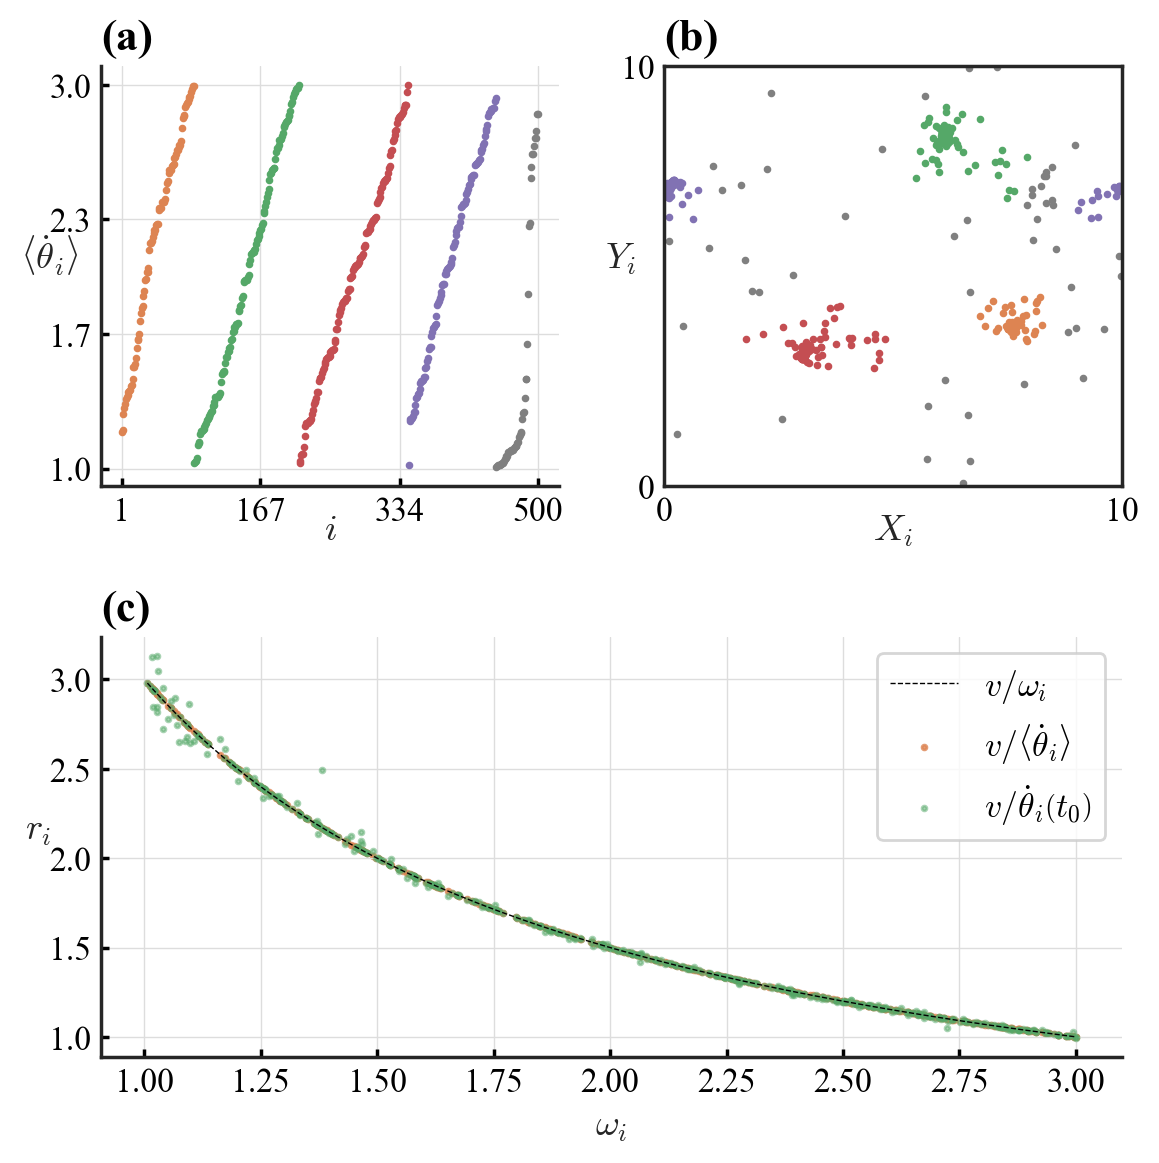

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 6))

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

model = SingleDistribution(strengthLambda=0.035, distanceD0=0.2, boundaryLength=10, savePath="./data")
sa = StateAnalysis(model, classDistance=0.5)
centers = sa.centers
omegaTheta = model.omegaTheta
classes, centers = sa.get_classes_centers()
bigClusters = dict()
dirftCluster = list()
for classNum in classes:
    if len(classes[classNum]) > 20:
        bigClusters[classNum] = classes[classNum]
    else:
        dirftCluster += classes[classNum]

# ax1.scatter(np.arange(1, model.agentsNum + 1), np.sort(omegaTheta), s=3)
cumsumNums = 0
for classNum in bigClusters:
    classIdx = bigClusters[classNum]
    ax1.scatter(np.arange(cumsumNums + 1, cumsumNums + len(classIdx) + 1), np.sort(omegaTheta[classIdx]), s=3, alpha=1, color=f"C{classNum}")
    ax2.scatter(x=centers[classIdx, 0], y=centers[classIdx, 1], s=3, alpha=1, color=f"C{classNum}")
    cumsumNums += len(classIdx)

ax1.scatter(np.arange(cumsumNums + 1, cumsumNums + len(dirftCluster) + 1), np.sort(omegaTheta[dirftCluster]), s=3, alpha=1, color="gray")
ax1.set_xlabel(r"$i$", labelpad=-5)
ax1.set_ylabel(r"$\left< \dot{\theta}_i \right>$", rotation=0, labelpad=0)
ax1.set_yticks(np.linspace(1, 3, 4).round(1))
ax1.set_xticks(np.linspace(1, 500, 4).round())

ax2.scatter(x=centers[dirftCluster, 0], y=centers[dirftCluster, 1], s=3, alpha=1, color="gray")
ax2.set_xticks([0, 10])
ax2.set_yticks([0, 10])
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.set_xlabel(r"$X_i$", labelpad=-5)
ax2.set_ylabel(r"$Y_i$", rotation=0, labelpad=0)
ax2.tick_params(direction='in', length=0)

centerNoMod = sa.centersNoMod
lastPositionX, lastPhaseTheta, lastPointTheta = sa.get_state(-1)
sort = np.argsort(omegaTheta)
sortedOmega = omegaTheta[sort]
distances = np.sqrt(np.sum((centerNoMod - lastPositionX)**2, axis=1))
ax3.plot(sortedOmega, 3 / sortedOmega, linestyle="--", color="black", lw=0.5, label=r"$v/\omega_i$", zorder=3)
ax3.scatter(omegaTheta, 3 / sa.totalPointTheta[1:].mean(axis=0) / 100, label=r"$v/\left<\dot{\theta}_i \right>$", s=3, color="C1", zorder=0, alpha=0.8)
ax3.scatter(omegaTheta, distances, label=r"$v/\dot{\theta}_i\left( t_0 \right)$", s=3, color="C2", zorder=1, alpha=0.5)
ax3.legend([
    r"$v/\omega_i$", r"$v/\left<\dot{\theta}_i \right>$", r"$v/\dot{\theta}_i\left( t_0 \right)$"
])
ax3.set_xlabel(r"$\omega_i$")
ax3.set_ylabel(r"$r_i$", rotation=0)

for ax in [ax1, ax3]:
    ax.grid(True)
    ax.tick_params(direction='in', length=3)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

ax1.set_title("(a)", loc="left", fontweight="bold", fontsize=16)
ax2.set_title("(b)", loc="left", fontweight="bold", fontsize=16)
ax3.set_title("(c)", loc="left", fontweight="bold", fontsize=16)

plt.tight_layout()
plt.savefig(f"PJT_C_Fig/mono3.pdf", bbox_inches="tight")